# Wikipedia Admin Election Prediction Model

This notebook implements a logistic regression model to predict the outcome of Wikipedia administrator elections based on article edit interactions between voters and candidates. The model uses features extracted from the edit history to predict whether a voter will support or oppose a candidate's nomination.

## Data and Feature Overview
The model uses features extracted from Wikipedia article edit histories, including:
- Interaction patterns between voters and candidates
- Temporal aspects of their interactions
- Edit characteristics and behaviors

These features are combined with actual voting records to train and evaluate the prediction model.

## Setup and Dependencies
First, we import the necessary libraries:
- `glob`: For file pattern matching
- `numpy` and `pandas`: For data manipulation
- `sklearn`: For machine learning components
- `tqdm`: For progress tracking

In [ ]:
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Split
We load the feature files containing article edit interactions and split them into training and test sets. Each file contains features for specific voter-candidate pairs on different dates. We use an 80-20 train-test split with a fixed random seed for reproducibility.

In [3]:
files = glob.glob("../data/features/article_edits.*.csv")
fit, test = train_test_split(files, test_size=0.2, random_state=42)

## Data Processing
The `load_data` function performs several key steps:
1. Loads individual feature files and combines them
2. Adds timestamp information from file names
3. Renames user columns for clarity
4. Merges with actual voting data
5. Cleans up the dataset by removing missing values

In [4]:
votes = pd.read_csv("../data/votes_with_election_info.csv")
votes["start_time"] = pd.to_datetime(votes["start_time"]).dt.strftime("%Y-%m-%d")

def load_data(files: list[str]) -> pd.DataFrame:
    data = []

    for file in tqdm(files):
        df = pd.read_csv(file)
        date = file.split(".")[3]
        df["start_time"] = date

        data.append(df)

    data = pd.concat(data, ignore_index=True)

    map = {"user1": "voter", "user2": "candidate"}
    data.rename(columns=map, inplace=True)
    features = data.merge(votes, how="left", on=["voter", "candidate", "start_time"], suffixes=(None, None))
    features = features[list(data.columns) + ["vote"]]
    features.dropna(inplace=True)
    features.drop(columns=["start_time"], inplace=True)

    return features

In [25]:
train_data = load_data(fit)
test_data = load_data(test)

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

## Feature Preprocessing
The `extract_data` function prepares the features for modeling:
1. Removes neutral votes (vote = 0)
2. Converts votes to binary format (1 for support, 0 for oppose)
3. Applies min-max scaling to normalize features
4. Returns processed features, labels, and the fitted scaler

In [50]:
def extract_data(data: pd.DataFrame, scaler: MinMaxScaler = None) -> tuple[pd.DataFrame, pd.Series, MinMaxScaler]:
    df = data.copy()
    df = df[df["vote"] != 0]
    df["vote"] = df["vote"].apply(lambda x: 1 if x == 1 else 0)

    column_filter = df.columns[2:-1]
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(df[column_filter])
    df[column_filter] = scaler.transform(df[column_filter])

    return df[column_filter], df["vote"], scaler

## Model Training
We use `LogisticRegressionCV` with the following configuration:
- L1 regularization (Lasso) to perform feature selection
- 5-fold cross-validation
- ROC-AUC scoring metric
- Parallel processing for faster training

In [51]:
X_train, y_train, scaler = extract_data(train_data)

In [67]:
model = LogisticRegressionCV(
    penalty="l1",
    solver="liblinear",
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
)
model = model.fit(X_train, y_train)

## Feature Importance Analysis
We examine the model coefficients to understand which features are most important for predicting voting behavior. Positive coefficients indicate features associated with support votes, while negative coefficients suggest features linked to oppose votes.

In [65]:
for column, coef in zip(train_data.columns[2:-1], model.coef_.reshape(-1)):
    print(f"{column}: {coef:.4f}")

collaboration: 0.2562
pairwise_jaccard: -0.0170
participation_entropy: 0.8442
mutual_information: 0.1058
jaccard: 0.2060
adamic_adar: 0.0452
pref_attachment: 0.0201
pagerank_1: -0.1261
pagerank_2: 0.2255


## Model Evaluation
We evaluate the model's performance on the test set using the ROC-AUC score, which measures the model's ability to distinguish between support and oppose votes. A score of 0.5 indicates random guessing, while 1.0 represents perfect prediction.

In [68]:
X_test, y_test, scaler = extract_data(test_data, scaler)
X_test.shape

(2610, 9)

In [69]:
y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc:.4f}")

Test AUC: 0.5155


## ROC Curve Visualization
The Receiver Operating Characteristic (ROC) curve visualizes the model's performance across different classification thresholds:
- X-axis: False Positive Rate (proportion of incorrect oppose predictions)
- Y-axis: True Positive Rate (proportion of correct support predictions)
- Diagonal line: Random classifier performance
- Area Under the Curve (AUC): Overall model performance metric

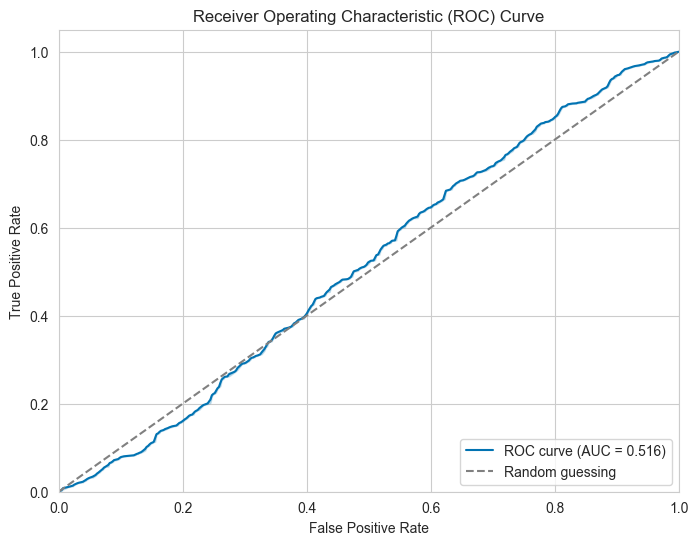

In [70]:
# Set seaborn style and palette
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Create plot
plt.figure(figsize=(8,6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc:.3f})')
sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')